In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pydicom, cv2
import os, pprint, random
from functools import lru_cache
from pathlib import Path
import matplotlib.pyplot as plt
print(tf.version.VERSION)

2.3.1


In [2]:
lidc_path = Path(os.environ['DATA_ALL']) / 'TCIA-LIDC' / 'LIDC-IDRI'
lidc_fn = tf.data.Dataset.from_generator(
    lambda:map(str, lidc_path.glob('**/*.dcm')), tf.string)

def tensor2str(str_tensor:tf.Tensor):
    return str(str_tensor.numpy(), 'ascii')

pprint.pprint([tensor2str(fn) for fn in lidc_fn.take(5)])

['G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000001.dcm',
 'G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000002.dcm',
 'G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000003.dcm',
 'G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000004.dcm',
 'G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000005.dcm']


In [3]:
@lru_cache(maxsize=128)
def get_ds(fn_str:str):
    return pydicom.dcmread(fn_str)

def get_ds_attr(fn_tensor:tf.Tensor, attr_name:tf.Tensor, default_value):
    if random.random() < 0.0: print(fn_tensor, end='\r')
    ds = get_ds(tensor2str(fn_tensor))
    return getattr(ds, tensor2str(attr_name), default_value)

attr_names_dtypes = \
    [('PatientID', '<none>', tf.string),
     ('SeriesInstanceUID', '<none>', tf.string),
     ('Modality', '<none>', tf.string),
     ('SOPInstanceUID', '<none>', tf.string),   
     ('FrameOfReferenceUID', '<none>', tf.string),
     ('PixelSpacing', [0.], tf.float32),
     ('ImagePositionPatient', [0.], tf.float32),
     ('pixel_array', [0], tf.int16)]

def make_dcm_dict(fn_tensor:tf.Tensor, attr_names_dtypes=attr_names_dtypes):
    attr_dict = {'dcm_fn': fn_tensor}
    for attr_name,default_value,dtype in attr_names_dtypes:
        attr_dict[attr_name] = \
            tf.py_function(get_ds_attr,
                           [fn_tensor, attr_name, default_value], dtype)
    return attr_dict

lidc_dict = lidc_fn.map(make_dcm_dict).filter(lambda item: tf.equal('CT', item['Modality']))
pprint.pprint([item for item in lidc_dict.take(2)])

[{'FrameOfReferenceUID': <tf.Tensor: shape=(), dtype=string, numpy=b'1.3.6.1.4.1.14519.5.2.1.6279.6001.229925374658226729607867499499'>,
  'ImagePositionPatient': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-166. , -171.7, -207.5], dtype=float32)>,
  'Modality': <tf.Tensor: shape=(), dtype=string, numpy=b'CT'>,
  'PatientID': <tf.Tensor: shape=(), dtype=string, numpy=b'LIDC-IDRI-0001'>,
  'PixelSpacing': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.703125, 0.703125], dtype=float32)>,
  'SOPInstanceUID': <tf.Tensor: shape=(), dtype=string, numpy=b'1.3.6.1.4.1.14519.5.2.1.6279.6001.143451261327128179989900675595'>,
  'SeriesInstanceUID': <tf.Tensor: shape=(), dtype=string, numpy=b'1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192'>,
  'dcm_fn': <tf.Tensor: shape=(), dtype=string, numpy=b'G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000001.dcm'>,
  'pixel_array': <tf.Tensor: shape=(512, 512), dtype=int16, numpy=
array(

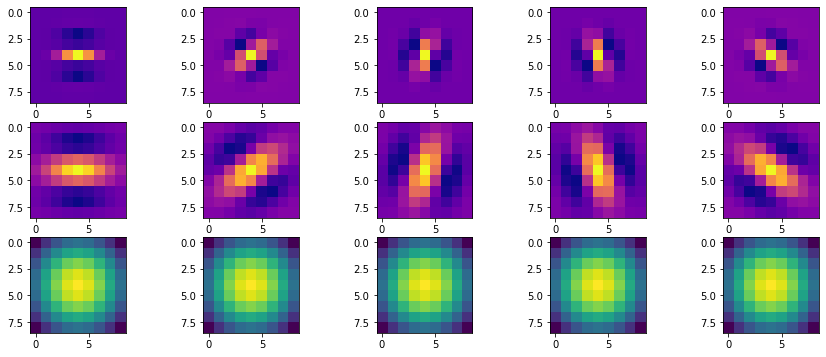

In [13]:
def kernels2tensor(kernels, dtype=tf.float32):
    kernels = np.moveaxis(np.expand_dims(kernels, axis=-1), 0,-1)
    return tf.constant(kernels, dtype=dtype)

def complex_exp(xs, ys, freq, angle_rad):
    return np.exp(freq * (xs*np.sin(angle_rad) + ys*np.cos(angle_rad)) * 1.0j)

def gauss(xs, ys, sigma):
    return (1 / (2 * np.pi * sigma**2)) \
        * np.exp(-(xs*xs + ys*ys) / (2.*sigma*sigma)) 

def make_meshgrid(sz=9):
    return np.meshgrid(np.linspace(-(sz//2), sz//2, sz),
                         np.linspace(-(sz//2), sz//2, sz))

def make_gabor_kernels(xs, ys, directions=3, freqs=[2.0, 1.0]):
    """ """
    angles_rad = [n * np.pi/float(directions) 
                  for n in range(directions)]    
    sine_kernels = kernels2tensor(
        [complex_exp(xs,ys,freq,angle_rad) 
             for freq in freqs
                for angle_rad in angles_rad])    
    sigmas = [2./freq for freq in freqs]
    gauss_kernels = kernels2tensor(
        [gauss(xs,ys,sigma) 
             for sigma in sigmas])
    gauss_kernels = np.repeat(gauss_kernels,
                              sine_kernels.shape[-1] // gauss_kernels.shape[-1], axis=-1)    
    
    bank = gauss_kernels * sine_kernels
    g0 = kernels2tensor([gauss(xs,ys,4./freqs[-1])])
    return tf.concat([bank, g0], -1)

directions = 5
freqs = [np.sqrt(3.0), 1.0]
xs,ys = make_meshgrid(sz=9)
gabor_kernels = make_gabor_kernels(xs, ys, directions=directions, freqs=freqs)
fig,axs = plt.subplots(len(freqs)+1, directions, figsize=(directions*3,len(freqs)*3))
for n in range(directions):
    for m in range(len(freqs)):
        img = tf.squeeze(gabor_kernels[...,0, m*directions+n])
        axs[m][n].imshow(tf.math.real(img), cmap='plasma')
g0 = tf.squeeze(gabor_kernels[...,0,-1])
for n in range(directions):
    axs[len(freqs)][n].imshow(tf.squeeze(g0))

In [14]:
def conv2d_sq(img:tf.Tensor, kernels:tf.Tensor):
    """ """
    if kernels.dtype == tf.complex64:
        return tf.nn.conv2d(img, tf.math.real(kernels), strides=1, padding='SAME') ** 2 \
                + tf.nn.conv2d(img, tf.math.imag(kernels), strides=1, padding='SAME') ** 2
    return tf.nn.conv2d(img, kernels, strides=1, padding='SAME') ** 2

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
sz = 32

def resize_filter(img_pixels):
    """ """
    img_pixels = img_pixels.numpy().astype(np.uint16)
    img_pixels -= np.min(img_pixels)
    img_pixels = cv2.resize(img_pixels, (sz,sz), interpolation = cv2.INTER_AREA)
    img_pixels = clahe.apply(img_pixels)
    img_pixels = np.reshape(img_pixels,(1,sz,sz,1))
    img_pixels = img_pixels.astype(np.float32)
    img_pixels = conv2d_sq(img_pixels, gabor_kernels)
    pixel_max, pixel_min = np.max(img_pixels), np.min(img_pixels)
    return (img_pixels - pixel_min) / (pixel_max - pixel_min)

def process_pixels(dict_item):
    """ """
    dict_item = dict_item.copy()
    pixel_array = dict_item['pixel_array']
    dict_item['original_pixel_min'], dict_item['original_pixel_max'] = \
        tf.math.reduce_min(pixel_array), tf.math.reduce_max(pixel_array)
    filter_response = tf.py_function(resize_filter, [pixel_array], tf.float32)
    dict_item['filter_response'] = filter_response
    del dict_item['pixel_array']
    return dict_item

lidc_processed = lidc_dict.map(process_pixels)
pprint.pprint([item for item in lidc_processed.take(2)])

[{'FrameOfReferenceUID': <tf.Tensor: shape=(), dtype=string, numpy=b'1.3.6.1.4.1.14519.5.2.1.6279.6001.229925374658226729607867499499'>,
  'ImagePositionPatient': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-166. , -171.7, -207.5], dtype=float32)>,
  'Modality': <tf.Tensor: shape=(), dtype=string, numpy=b'CT'>,
  'PatientID': <tf.Tensor: shape=(), dtype=string, numpy=b'LIDC-IDRI-0001'>,
  'PixelSpacing': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.703125, 0.703125], dtype=float32)>,
  'SOPInstanceUID': <tf.Tensor: shape=(), dtype=string, numpy=b'1.3.6.1.4.1.14519.5.2.1.6279.6001.143451261327128179989900675595'>,
  'SeriesInstanceUID': <tf.Tensor: shape=(), dtype=string, numpy=b'1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192'>,
  'dcm_fn': <tf.Tensor: shape=(), dtype=string, numpy=b'G:\\DataAll\\TCIA-LIDC\\LIDC-IDRI\\LIDC-IDRI-0001\\01-01-2000-30178\\3000566-03192\\000001.dcm'>,
  'filter_response': <tf.Tensor: shape=(1, 32, 32, 11), dtype=float32, nu

In [16]:
def per_filter_stats(current_stats, item):
    tf.print(current_stats)
    next_stats = tf.reduce_max(item['filter_response'], axis=[0,1,2])
    return tf.math.maximum(current_stats, next_stats)

lidc_processed_max = \
    lidc_processed.take(2000).reduce(
        tf.constant(np.zeros(11, np.float32)), per_filter_stats)

print(lidc_processed_max)

[0 0 0 ... 0 0 0]
[0.502638876 0.361410141 0.436954916 ... 0.552838147 0.403166771 1]
[0.516847849 0.361506313 0.487581521 ... 0.552838147 0.422319144 1]
[0.5286479 0.361506313 0.487581521 ... 0.564594805 0.445771217 1]
[0.5286479 0.369910836 0.491114557 ... 0.564594805 0.445771217 1]
[0.530455291 0.369910836 0.491114557 ... 0.577754498 0.445771217 1]
[0.530455291 0.372394681 0.491114557 ... 0.577754498 0.445771217 1]
[0.530455291 0.394294888 0.491114557 ... 0.577754498 0.445771217 1]
[0.532218933 0.394294888 0.491114557 ... 0.577754498 0.445771217 1]
[0.532218933 0.394294888 0.491114557 ... 0.577754498 0.445771217 1]
[0.532218933 0.394294888 0.491114557 ... 0.577754498 0.445771217 1]
[0.542309463 0.394294888 0.491114557 ... 0.592575192 0.445771217 1]
[0.542309463 0.394294888 0.491114557 ... 0.592575192 0.445771217 1]
[0.542309463 0.394294888 0.491114557 ... 0.592575192 0.445771217 1]
[0.542309463 0.394294888 0.491114557 ... 0.592575192 0.445771217 1]
[0.542309463 0.394294888 0.4911145

[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.394294888 0.505862951 ... 0.60357

[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.433826447 0.505862951 ... 0.60357

[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.60357

[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.60357

[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.60357

[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.505862951 ... 0.60357

[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.603576243 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.60357

[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.60896

[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.60896

[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.60896

[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.608965695 0.479993165 1]
[0.577083766 0.445177078 0.522786915 ... 0.61151

[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.611515284 0.489656925 1]
[0.577083766 0.445177078 0.523289859 ... 0.61151

[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.62072

[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.62072

[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.62072

[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.620722294 0.489656925 1]
[0.577083766 0.445177078 0.525164485 ... 0.62072

In [17]:
def norm_filter_response(item):
    item = item.copy()
    item['filter_response'] = item['filter_response'] / lidc_processed_max
    return item

lidc_processed_norm = lidc_processed.map(norm_filter_response)

for result in lidc_processed_norm.take(2):
    print(tf.reduce_max(result['filter_response'], axis=[0,1,2]))

tf.Tensor(
[0.87099814 0.8118346  0.8320344  0.83038926 0.69836974 0.8833439
 0.86228937 0.85706383 0.89063686 0.8233658  1.        ], shape=(11,), dtype=float32)
tf.Tensor(
[0.89562017 0.8120506  0.9284358  0.8634556  0.7232085  0.90160185
 0.8851829  0.8674752  0.88907254 0.8624797  1.        ], shape=(11,), dtype=float32)


In [18]:
lidc_metadata_csv = next((Path(os.environ['DATA_ALL']) / 'TCIA-LIDC').glob('*.csv'))
lidc_md = pd.read_csv(lidc_metadata_csv)
all_subjects = list(set(lidc_md['Patient Id']))
split_len = len(all_subjects) // 10

def is_test(item):
    return tf.reduce_any(tf.equal(tf.constant(all_subjects[:split_len]), 
                                  item['PatientID']))

def is_train(item):
    return tf.reduce_any(tf.equal(tf.constant(all_subjects[split_len:]), 
                                  item['PatientID']))

def get_filter_response(item): 
    return item['filter_response']

train_dataset = lidc_processed_norm.filter(is_test)
test_dataset = lidc_processed_norm.filter(is_train)
print(f"Split in to {len(all_subjects) - split_len} training and {split_len} testing")
for item in train_dataset.map(get_filter_response).unbatch().batch(25).take(3):
    print(item.shape)

Split in to 909 training and 101 testing
(25, 32, 32, 11)
(25, 32, 32, 11)
(25, 32, 32, 11)


In [19]:
samples, filter_count = 4, gabor_kernels.shape[-1]
images = [[np.squeeze(item['filter_response'][...,n])
               for item in train_dataset.take(samples)] 
                  for n in range(filter_count)]

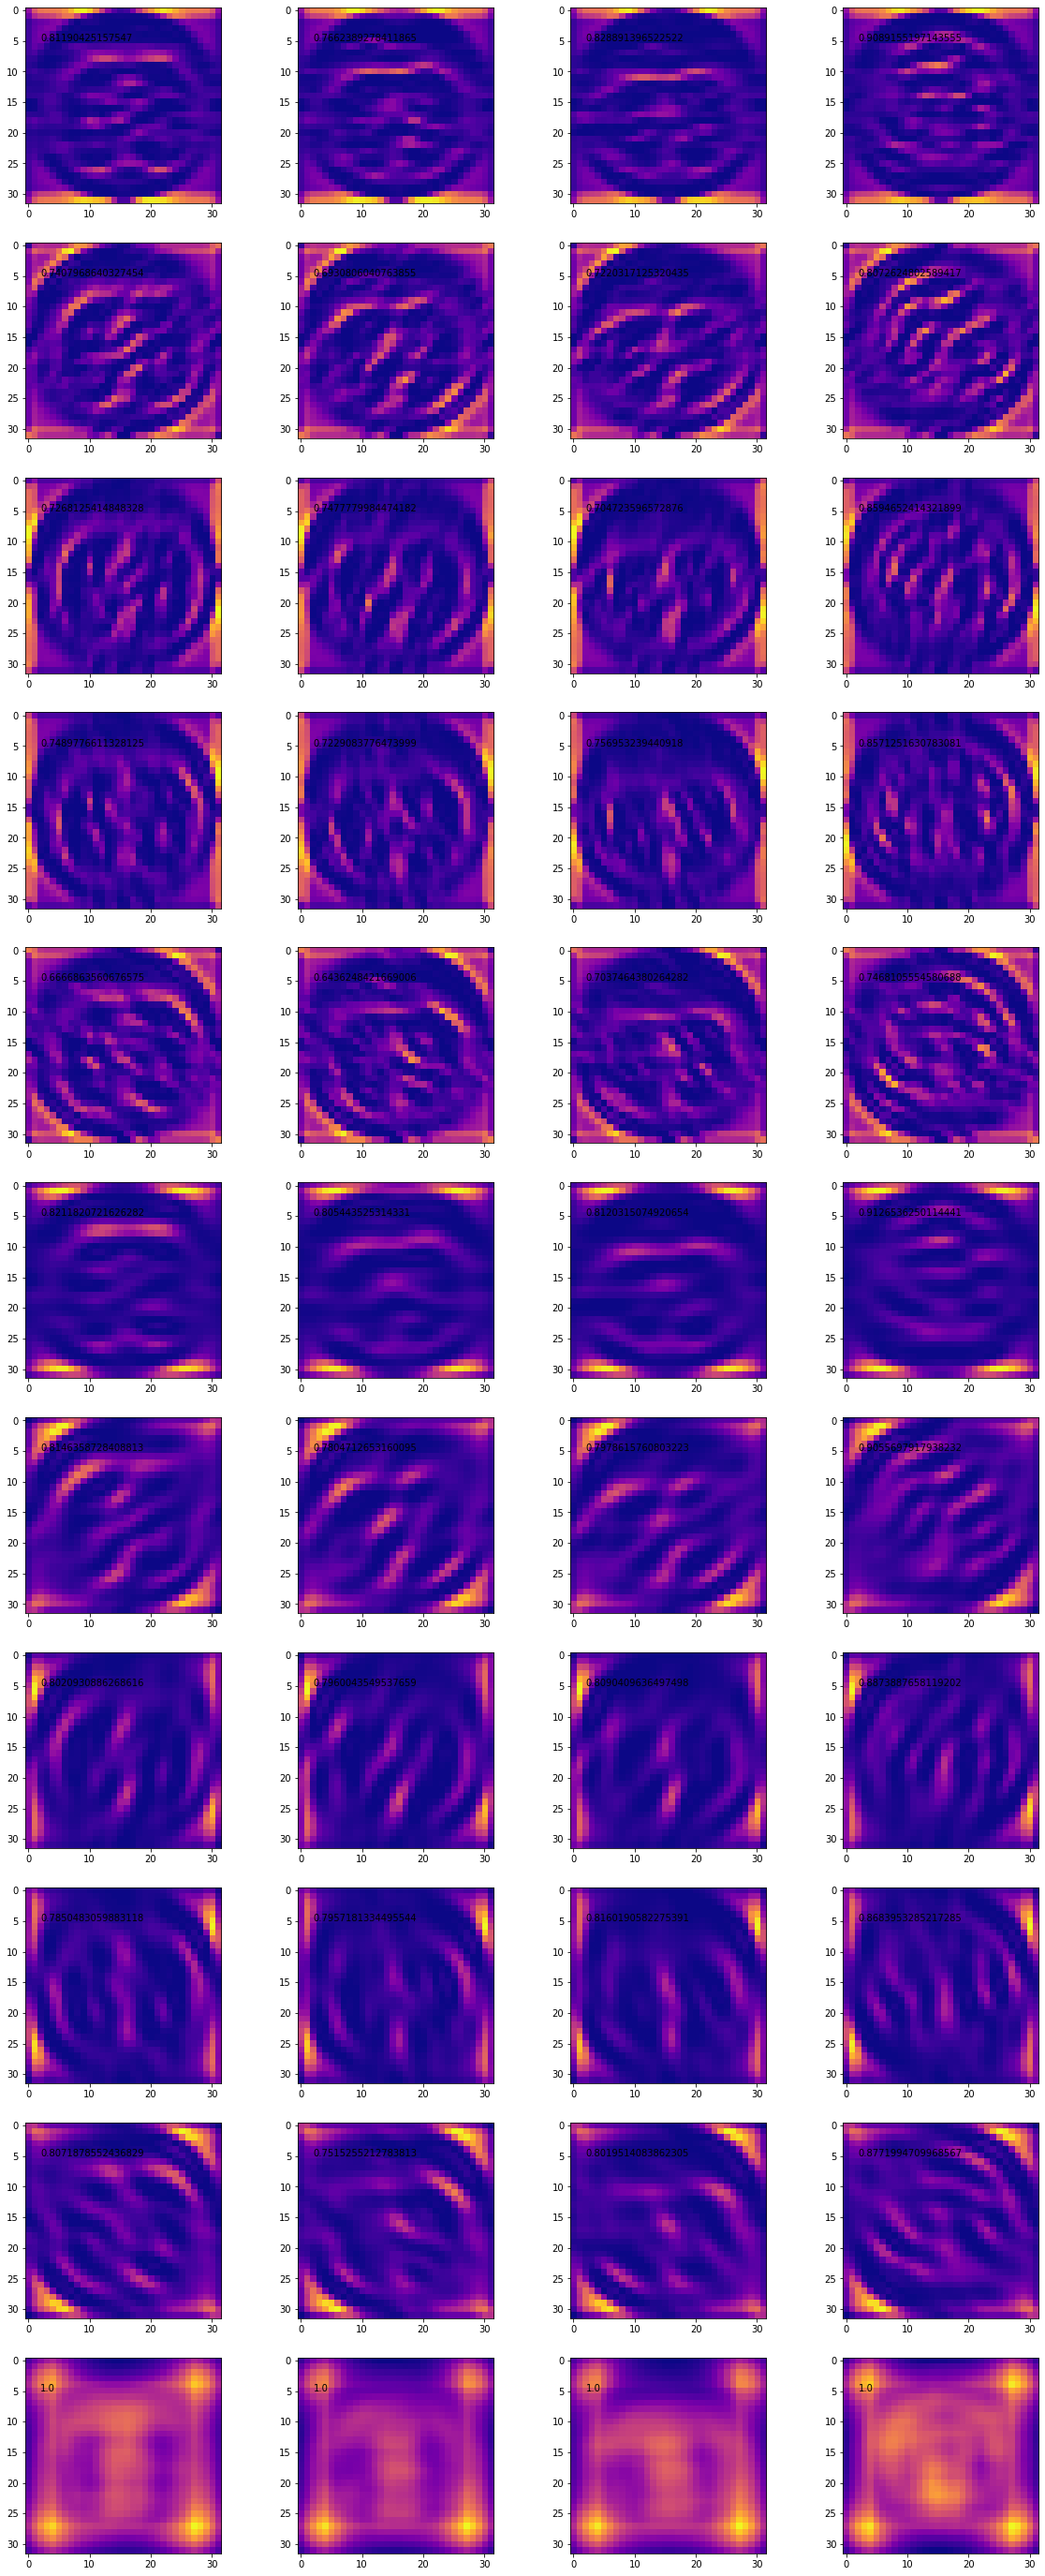

In [20]:
fig, axs = plt.subplots(filter_count, samples, figsize=(20,50))
for m in range(filter_count):
    for n in range(samples):
        axs[m][n].imshow(images[m][n], cmap='plasma')
        axs[m][n].text(2,5,f"{np.max(images[m][n])}")

In [21]:
from tensorflow.keras import layers, losses, Model
latent_dim = 25
input_layer = layers.Input(shape=(sz,sz,filter_count))
encoder = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(latent_dim, activation='relu'),
])

decoder = tf.keras.Sequential([
    layers.Dense(sz*sz*filter_count, activation='sigmoid'),
    layers.Reshape((sz, sz, filter_count))
])

autoencoder = Model(input_layer, decoder(encoder(input_layer)))
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11264)             0         
_________________________________________________________________
dense (Dense)                (None, 25)                281625    
Total params: 281,625
Trainable params: 281,625
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 11264)             292864    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 11)        0         
Total params: 292,864
Trainable params: 292,864
Non-trainable params: 0
_________________________________________________________________
Model: "functional_1"


In [ ]:
opt = tf.optimizers.Adam(1e-4)
shuffled = train_dataset.map(get_filter_response).shuffle(buffer_size=16)
print('shuffled')

batches = shuffled.unbatch().batch(100).prefetch()
print('batched')

for batch in batches:
    print(batch.shape)

In [27]:
for batch in batches:
    with tf.GradientTape() as t:
        reconstructed = autoencoder(batch)
        loss = tf.reduce_mean((reconstructed - batch) ** 2)
        if random.random() < 0.01: print(loss)
    grad = t.gradient([loss], autoencoder.trainable_variables)
    # print(grad)
    opt.apply_gradients(zip(grad, autoencoder.trainable_variables))

tf.Tensor(0.007867998, shape=(), dtype=float32)


KeyboardInterrupt: 

In [ ]:
im = next(iter(train_dataset.map(get_filter_response)))    
print(im.shape)
print(decoder(encoder(im)).shape)

In [ ]:
fig, axs = plt.subplots(filter_count, 2, figsize=(20,50))
im_filtered = next(iter(train_dataset.map(get_filter_response)))
recon_im = decoder(encoder(im_filtered))
for m in range(filter_count):  
    axs[m][0].imshow(np.squeeze(im_filtered[0,...,m]), cmap='plasma')
    axs[m][1].imshow(np.squeeze(recon_im[0,...,m]), cmap='plasma')

In [ ]:
current_value = tf.Variable(0.5 * np.ones((1,sz,sz,1)), dtype=tf.float32)
denorm_filtered = recon_im * lidc_processed_max
optimizer = tf.optimizers.Adam(1e-3)
for n in range(10000):
    with tf.GradientTape() as tape:
        current_filtered = conv2d_sq(current_value, gabor_kernels)
        loss = tf.reduce_mean((current_filtered - denorm_filtered) ** 2)
        if random.random() < 0.01: print(loss)
    grad = tape.gradient(loss, current_value)
    optimizer.apply_gradients(zip([grad], [current_value]))
    
plt.imshow(np.squeeze(current_value[0,...,0]), cmap='gray')

In [ ]:
for n in range(100):
    with tf.GradientTape() as tape:
        current_filtered = conv2d_sq(current_value, gabor_kernels)
        loss = tf.reduce_mean((current_filtered - denorm_filtered) ** 2)
        if random.random() < 0.01: print(loss)
    grad = tape.gradient(loss, current_value)
    optimizer.apply_gradients(zip([grad], [current_value]))

plt.imshow(np.abs(np.squeeze(current_value[0,...,0])), cmap='gray', vmin=-0.5, vmax=1.)